In [ ]:
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.utils
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from google.colab import drive
from google.colab import files
import zipfile
import os

In [ ]:
# Paramètres d'entraînement
batch_size = 64
epochs = 150
num_classes = 10
depth = 20
subtract_pixel_mean = True

In [ ]:
uploaded = files.upload()

zip_path = "/content/data_2.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/dossier_extrait_2")

# Vérifiez le contenu extrait
os.listdir("/content/dossier_extrait_2")

Saving data_2.zip to data_2 (1).zip


['data_2']

In [ ]:
num_classes = 4
subtract_pixel_mean = True

# Chemin données
data_dir = "/content/dossier_extrait_2/data_2"

# Transformations des images (on garde des changements minimaux)
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(p=0.5),  # Retournement horizontal aléatoire
    transforms.RandomRotation(15),  # Rotation aléatoire de ±15 degrés
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Altération des couleurs
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Déplacement aléatoire
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# Chargement des données
trainset = datasets.ImageFolder(root=os.path.join(data_dir, "Train"), transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = datasets.ImageFolder(root=os.path.join(data_dir, "Test"), transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Récupérer les noms des classes
classes = trainset.classes
print("Classes détectées:", classes)

# Définition du modèle ResNet-20 (inchangé)
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=4):  # Adapter pour 4 classes
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def resnet20():
    return ResNet(BasicBlock, [3, 3, 3], num_classes=4)

# Initialisation du modèle
model_v = resnet20().to(device)

# Définir l'optimiseur et la fonction de perte
optimizer = optim.SGD(model_v.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Ajustement du learning rate
def adjust_learning_rate(optimizer, epoch):
    if epoch >= 80:
        lr = 0.01
    else:
        lr = 0.1
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Entraînement
for epoch in range(epochs):
    model_v.train()
    adjust_learning_rate(optimizer, epoch)
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_v(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Évaluation sur les données de validation
    model_v.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model_v(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(testloader)
    val_accuracy = 100 * correct / total
    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch: {epoch + 1}, Learning Rate: {current_lr}, Val Accuracy: {val_accuracy:.2f}%, Val Loss: {val_loss:.3f}")

print("Finished Training")


Classes détectées: ['brown_liquid_meat', 'defect_meat', 'healthy_meat', 'not_meat']
Epoch: 1, Learning Rate: 0.1, Val Accuracy: 39.34%, Val Loss: 1.293
Epoch: 2, Learning Rate: 0.1, Val Accuracy: 32.79%, Val Loss: 2.690
Epoch: 3, Learning Rate: 0.1, Val Accuracy: 21.31%, Val Loss: 16.340
Epoch: 4, Learning Rate: 0.1, Val Accuracy: 9.84%, Val Loss: 172.417
Epoch: 5, Learning Rate: 0.1, Val Accuracy: 9.84%, Val Loss: 626.845
Epoch: 6, Learning Rate: 0.1, Val Accuracy: 39.34%, Val Loss: 1198.302
Epoch: 7, Learning Rate: 0.1, Val Accuracy: 9.84%, Val Loss: 1068.332
Epoch: 8, Learning Rate: 0.1, Val Accuracy: 9.84%, Val Loss: 1457.523
Epoch: 9, Learning Rate: 0.1, Val Accuracy: 9.84%, Val Loss: 521.072
Epoch: 10, Learning Rate: 0.1, Val Accuracy: 40.98%, Val Loss: 314.863
Epoch: 11, Learning Rate: 0.1, Val Accuracy: 9.84%, Val Loss: 166.267
Epoch: 12, Learning Rate: 0.1, Val Accuracy: 8.20%, Val Loss: 55.763
Epoch: 13, Learning Rate: 0.1, Val Accuracy: 39.34%, Val Loss: 6.958
Epoch: 14, Lea

In [ ]:
save_path_2 = '/content/model_Resnet20_final_avec_viande.pth'
torch.save(model_v.state_dict(), save_path_2)
print(f"Model saved to {save_path_2}")

from google.colab import files
files.download(save_path_2)

Model saved to /content/model_Resnet20_final_avec_viande.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

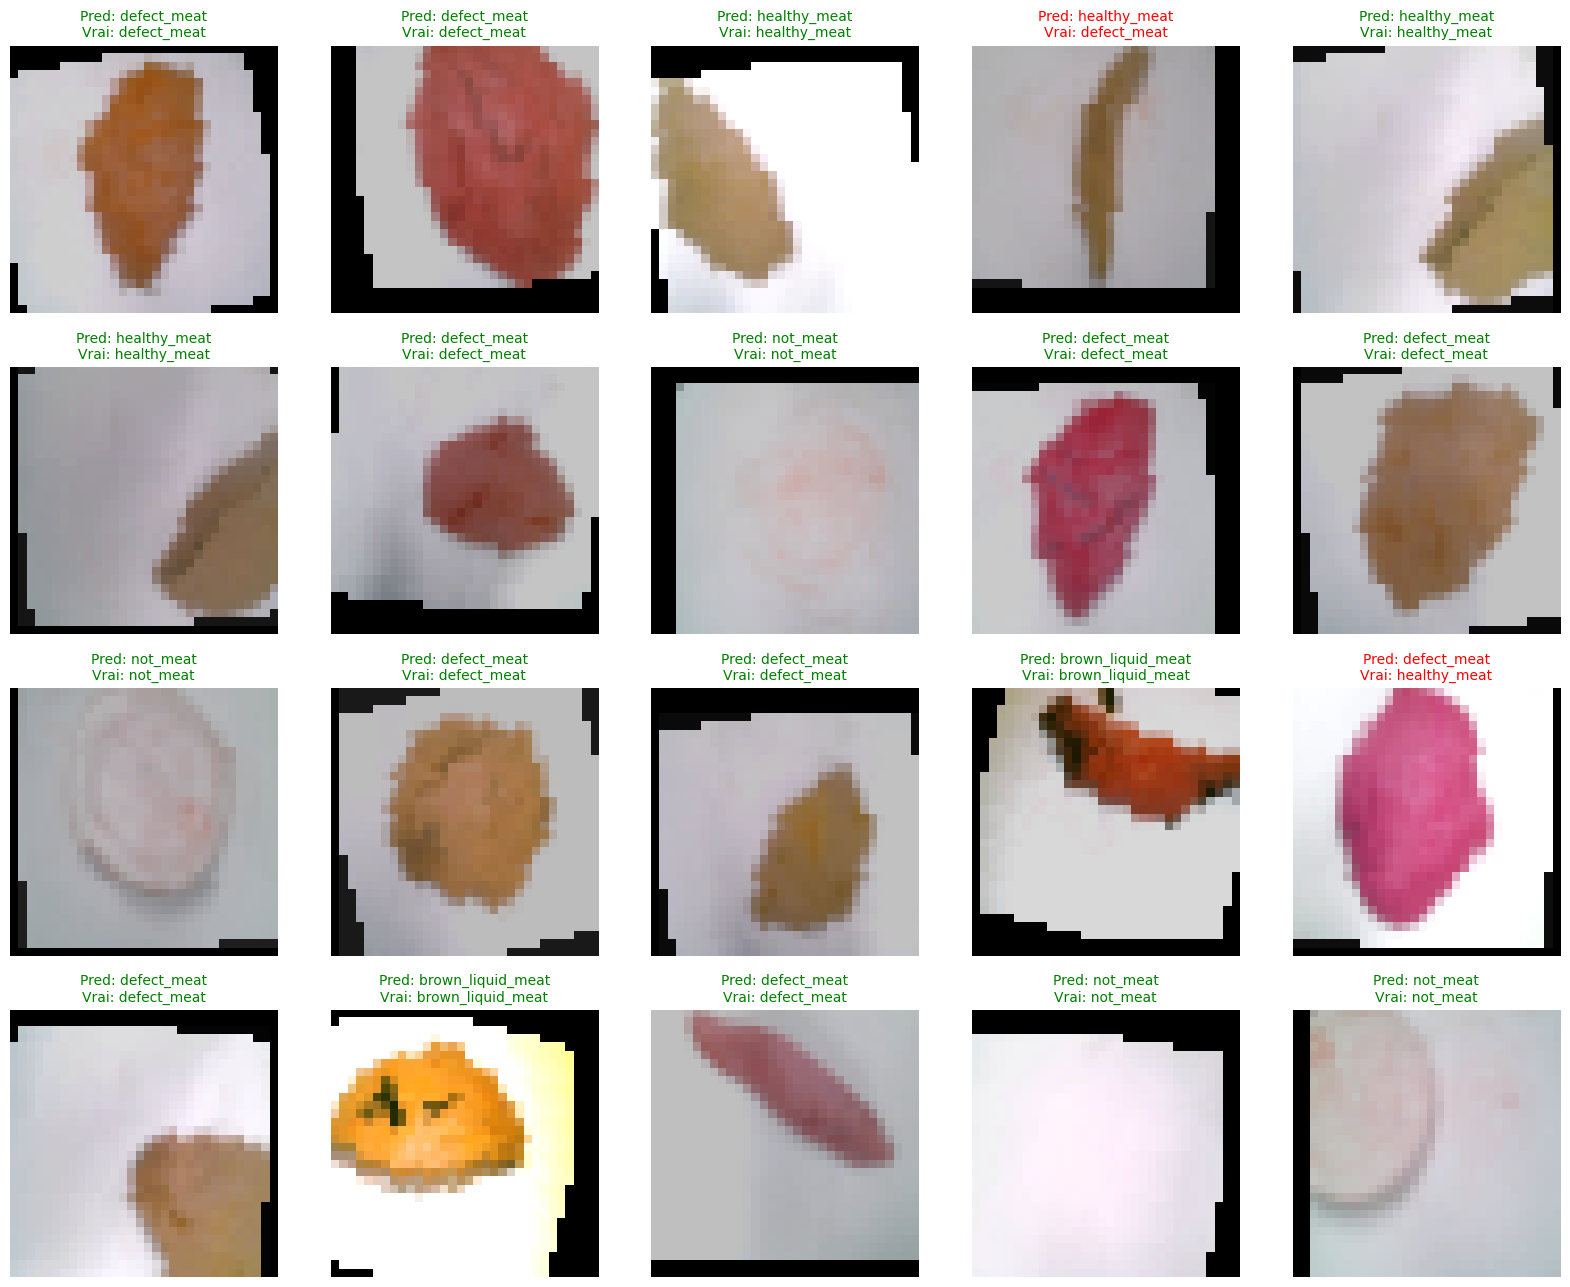

In [ ]:
# Obtenir toutes les images et labels du test set
all_images = []
all_labels = []

for images, labels in testloader:
    all_images.append(images)
    all_labels.append(labels)

# Concaténer toutes les images et labels
all_images = torch.cat(all_images, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Sélectionner aléatoirement 30 images
random_indices = random.sample(range(len(all_images)), 30)
random_images = all_images[random_indices]
random_labels = all_labels[random_indices]

# Envoyer les images au même device que le modèle
random_images = random_images.to(device)
random_labels = random_labels.to(device)

# Prédictions du modèle
outputs = model_v(random_images)
_, predicted = torch.max(outputs, 1)

# Déplacer les images vers le CPU pour affichage
random_images = random_images.cpu()
predicted = predicted.cpu()
random_labels = random_labels.cpu()

# Affichage des images avec leurs prédictions et vérités
fig, axes = plt.subplots(4, 5, figsize=(20, 16))  # 4 rangées et 5 colonnes pour 20 images
for i in range(20):
    title = f"Pred: {classes[predicted[i]]}\nVrai: {classes[random_labels[i]]}"
    axes[i // 5, i % 5].imshow(np.transpose((random_images[i] / 2 + 0.5).numpy(), (1, 2, 0)))  # Dénormalisation
    axes[i // 5, i % 5].set_title(title, fontsize=10, color='green' if predicted[i] == random_labels[i] else 'red')
    axes[i // 5, i % 5].axis('off')

plt.show()
